**Author**: Lulof Pirée

**Date**: June 2022

--------------------------------------------------------------------------------
Copyright (C) 2022 Lulof Pirée

This file is part of the snakes_spn program.

This program is free software:
you can redistribute it and/or modify it under the terms
of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.
If not, see <https://www.gnu.org/licenses/>.

--------------------------------------------------------------------------------
## File content
Main experiment: influence of the following variables
on the amount of inflammation-repression:
* $x_1$: Initial concentration (amount of tokens) of GbPdn.
* $x_2$: Rate constant of GbPdn cleaving ($GbPdn+Gba2 \rightarrow Pdn + Gba2$).
* $x_3$: Rate constant of Gr* unbinding ($Gr^* \rightarrow Gr + Pdn$).
* $x_4$: Rate constant of GrGbPdn unbinding ($GrGbPdn \rightarrow Gr + GbPdn$).

In [31]:
from typing import Sequence, Tuple, Any, Dict

import os
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from matplotlib.colorbar import Colorbar
from matplotlib.colors import Colormap
from matplotlib import colors
from matplotlib import cm
from matplotlib.transforms import Bbox
import itertools
import numpy as np

from spn_case_study.launch_experiment import (
    setup_init_markings_all_choices, setup_rates_all_choices)
from spn_case_study.run_grid_search import run_experiment, run_full_grid_search
from spn_case_study.petrinet import PLACES, VARS, TRANS, TRANS_TO_PLACES
from spn_tools.run_simulation import (plot_results, load_log,
    aggregate_dataset_in_timeboxes, get_num_timeboxes_for_fixed_duration)
from spn_case_study.auxiliary_tools import strip_prefix_number_from_string

## Constants

In [2]:
INIT_TOKEN_COUNT = 1000
# Amount of independent repetitions per parameter setup
NUM_REPETITIONS = 50

# Maximum of discrete transition-firings per simulation run
MAX_NUM_TRANSITIONS = 10000
# Maximum amount of simulated time passed before simulation is terminated
MAX_TIME_PASSED = 0.005

## Directory structure

All files should be saved into `main_exp_data`.
This contains 3 subdirectories:
* `const_unbind_rates`: for experiments that fix $x_3$ and $x_4$,
    but try many different values for $x_1$ and $x_2$.
    Contains, for each value $x_3 = CCCC$ 
    and each value of $x_4 = DDDD$
    a subdirectory `x3_CCCC__x4_DDDD`.
    Each such subdirecory contains a directory
    for each variation of $x_1 = AAAA$ and $x_2 = BBBB$,
    e.g., `x1_123e-4__x2_321e-2`.
* `vary_unbind_rates`: same as `const_unbind_rates`,
    but with $(x_3, x_4)$ swapped with $(x_1, x_2)$.
* `baseline`: for the single experiment that has $x_1=x_2=x_3=x_4=0$.
    Used an unrepressed inflammation baseline 
    to assess strength of inflammation-repression.

```
main_exp_data/

    const_unbind_rates/
        x3_CCCC__x4_DDDD/
            x1_AAAA__x2_BBBB/
                logs.json
                hyperparameters.json
            .../
        .../

    vary_unbind_rates/
        x1_AAAA__x2_BBBB/
            x3_CCCC__x4_DDDD/
                logs.json
                hyperparameters.json
            .../
        .../

    baseline/
        logs.json
        hyperparameters.json
```

In [3]:
MAIN_DIR_NAME = "main_exp_dir"
CONST_UNBIND_DIR_NAME = "const_unbind_rates"
VARYING_UNBIND_DIR_NAME = "vary_unbind_rates"
BASELINE_DIR_NAME = "baseline"

# Notebooks usually set the cwd to the directory containing the notebook itself.
print(f"Current directory: {os.getcwd()}")
if "main_experiment.ipynb" in os.listdir(os.getcwd()):
    MAIN_SAVE_DIR = os.path.join(os.getcwd(), MAIN_DIR_NAME)
else:
    raise RuntimeError("Wrong working directory.")

CONST_UNBIND_SAVE_DIR = os.path.join(MAIN_SAVE_DIR, CONST_UNBIND_DIR_NAME)
VARYING_UNBIND_SAVE_DIR = os.path.join(MAIN_SAVE_DIR, VARYING_UNBIND_DIR_NAME)
BASELINE_SAVE_DIR = os.path.join(MAIN_DIR_NAME, BASELINE_DIR_NAME)

all_subdirs = [CONST_UNBIND_SAVE_DIR, VARYING_UNBIND_SAVE_DIR,
                BASELINE_SAVE_DIR]
for dir_name in all_subdirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

Current directory: /home/nifrec/Vault/Documents/master_1/bio_modelling/model_ass/snakes_spn/spn_case_study


## Baseline experiment

Data for experiment 'main_exp_dir/baseline' already exists.


[Text(0, 0.5, 'Neutrophil concentration'),
 Text(0.5, 1.0, 'Neutrophil recruitment without repression')]

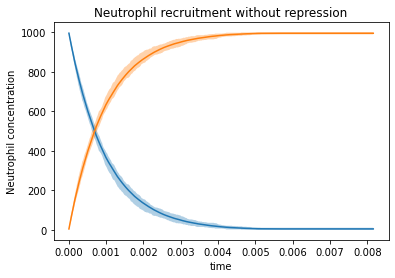

In [4]:
def check_experiment_already_done(dirname: str) -> bool:
    """
    Return whether is already a data-file of experimental data
    (a `logs.json` file) in the given directory.
    """
    dir_contents = os.listdir(dirname)
    if "logs.json" in dir_contents:
        print(f"Data for experiment '{dirname}' already exists.")
        return True
    return False

if not check_experiment_already_done(BASELINE_SAVE_DIR):
    init_markings = {name: (0,) for name in PLACES}
    init_markings["neutrophil_free"] = (INIT_TOKEN_COUNT,)
    init_markings["infl_sig"] = (INIT_TOKEN_COUNT,)

    rates = {name : "0" for name in TRANS}
    rates["recruit_neutrophil"] = f"{VARS['infl_sig']}*{VARS['neutrophil_free']}"

    run_experiment(rates, init_markings, BASELINE_SAVE_DIR, NUM_REPETITIONS, 
                        max_steps=MAX_NUM_TRANSITIONS, max_time=MAX_TIME_PASSED)


BASELINE_LOGS = load_log(os.path.join(BASELINE_SAVE_DIR, "logs.json"))
BASELINE_NUM_TIMEBOXES = 500
DESIRED_TIMEBOX_DURATION = MAX_TIME_PASSED/BASELINE_NUM_TIMEBOXES
num_timeboxes = get_num_timeboxes_for_fixed_duration(BASELINE_LOGS, 
                                        DESIRED_TIMEBOX_DURATION)
x_var = "time"
y_vars = ["neutrophil_free", "neutrophil_inflaming"]
ax = plot_results(BASELINE_LOGS, x_var, y_vars, 
             num_timeboxes, interval_type="min_max")
ax.set(ylabel="Neutrophil concentration",
    title="Neutrophil recruitment without repression")

### Comparison point
So judge the strength of inflammation-repression,
it is only fair to measure the inflammation strength
after **a fixes amount of simulated time passed**.
Fix this time to be the time after which half
the neutrophils have been recruited in the unrepressed case:

In [5]:
MAX_NEUTROPHILS_RECRUITED = INIT_TOKEN_COUNT//2
baseline_neutrophil_means, timebox_duration = \
    aggregate_dataset_in_timeboxes(BASELINE_LOGS, x_var="time",
        y_vars=["neutrophil_inflaming"], 
        num_timeboxes=BASELINE_NUM_TIMEBOXES)
baseline_neutrophil_means = \
    np.mean(baseline_neutrophil_means["neutrophil_inflaming"], axis=0)
i = 0
while baseline_neutrophil_means[i] < MAX_NEUTROPHILS_RECRUITED:
    i+=1
COMPARISON_TIMESTAMP = timebox_duration*i
print(COMPARISON_TIMESTAMP)

0.0006859455823488908


## First experiment: $x_3, x_4$ fixed

Values to try:
* $x_1 \in [10, 100, 1000, 2000, 3000] = [GbPdn]$
* $x_2 \in [0.001, 0.01, 1, 10, 100] = $ `CLEAVE_CONST`

In [6]:
# The ratio PDN_BIND_CONST-GBPDN_BIND_CONST is of interest.
# the absolute values would seem less relevant -- so fix this at 1:
PDN_BIND_CONST = 1
# It is given by the case-study provider that it is a 1000 times lower.
GBPDN_BIND_CONST = PDN_BIND_CONST/1000
# See the experiment `tune_inflam_repress_rate.ipynb`
# for the tuning of the inflammation-repression rate constant:
REPRESS_INFL_CONST = 10 
# Was fixed to this value while tuning the above:
NEUTROPHIL_RECRUIT_CONST = 1

# The variables to vary (x_1 and x_2):
GBPDN_INIT_MARKING_CHOICES = (10, 100, 1000, 2000, 3000)
CLEAVE_CONST_CHOICES = (0.001, 0.01, 1, 10, 100)

def setup_init_markings(gbpdn_init_markings: 
        Sequence[int] = GBPDN_INIT_MARKING_CHOICES) -> dict[str, Sequence[int]]:
    init_markings = {name: (0,) for name in PLACES}
    init_markings["gba2"] = (1000,)
    init_markings["gbpdn"] = gbpdn_init_markings
    init_markings["neutrophil_free"] = (1000,)
    init_markings["gr_free"] = (1000,)
    init_markings["infl_sig"] = (1000,)
    return init_markings

def setup_rates(cleave_rate_constants: Sequence[float|int]=CLEAVE_CONST_CHOICES,
                gr_pdn_decay_constants: Sequence[float|int]=("0",),
                gr_gbpdn_decay_constants: Sequence[float|int]=("0",)
                ) -> dict[str, Sequence[str]]:
    rates = {trans_name : ("0",) for trans_name in TRANS}
    rates["cleave"] = [
        f"{cleave_rate}*{VARS['gba2']}*{VARS['gbpdn']}"
        for cleave_rate in cleave_rate_constants]

    # Binding -- Mass Action
    rates["bind_pdn"] = (f"{PDN_BIND_CONST}*{VARS['pdn']}*{VARS['gr_free']}",)
    rates["bind_gbpdn"] = (f"{GBPDN_BIND_CONST}*{VARS['gbpdn']}*{VARS['gr_free']}",)

    rates["repress_infl"] = (f"{REPRESS_INFL_CONST} * "
        +f"{VARS['infl_sig']} * {VARS['gr_pdn']}",)
    rates["recruit_neutrophil"] = (f"{NEUTROPHIL_RECRUIT_CONST}*"
        + f"{VARS['neutrophil_free']}*{VARS['infl_sig']}",        
    )

    # Unbinding -- Mass Action
    rates["unbind_pdn"] = [f"{unbind_rate}*{VARS['gr_pdn']}"
        for unbind_rate in gr_pdn_decay_constants]
    rates["unbind_gbpdn"] = [f"{unbind_rate}*{VARS['gr_gbpdn']}"
        for unbind_rate in gr_gbpdn_decay_constants]

    return rates

In [7]:
subdir_name = "x3_0__x4_0"
subdir_path = os.path.join(CONST_UNBIND_SAVE_DIR, subdir_name)
if not os.path.exists(subdir_path):
    os.mkdir(subdir_path)

if not os.path.exists(os.path.join(subdir_path, "exp_0")):
    run_full_grid_search(setup_rates(), setup_init_markings(), subdir_path, 
                        NUM_REPETITIONS, max_steps=MAX_NUM_TRANSITIONS, 
                        max_time=MAX_TIME_PASSED)

### Graph-plots as sanity check

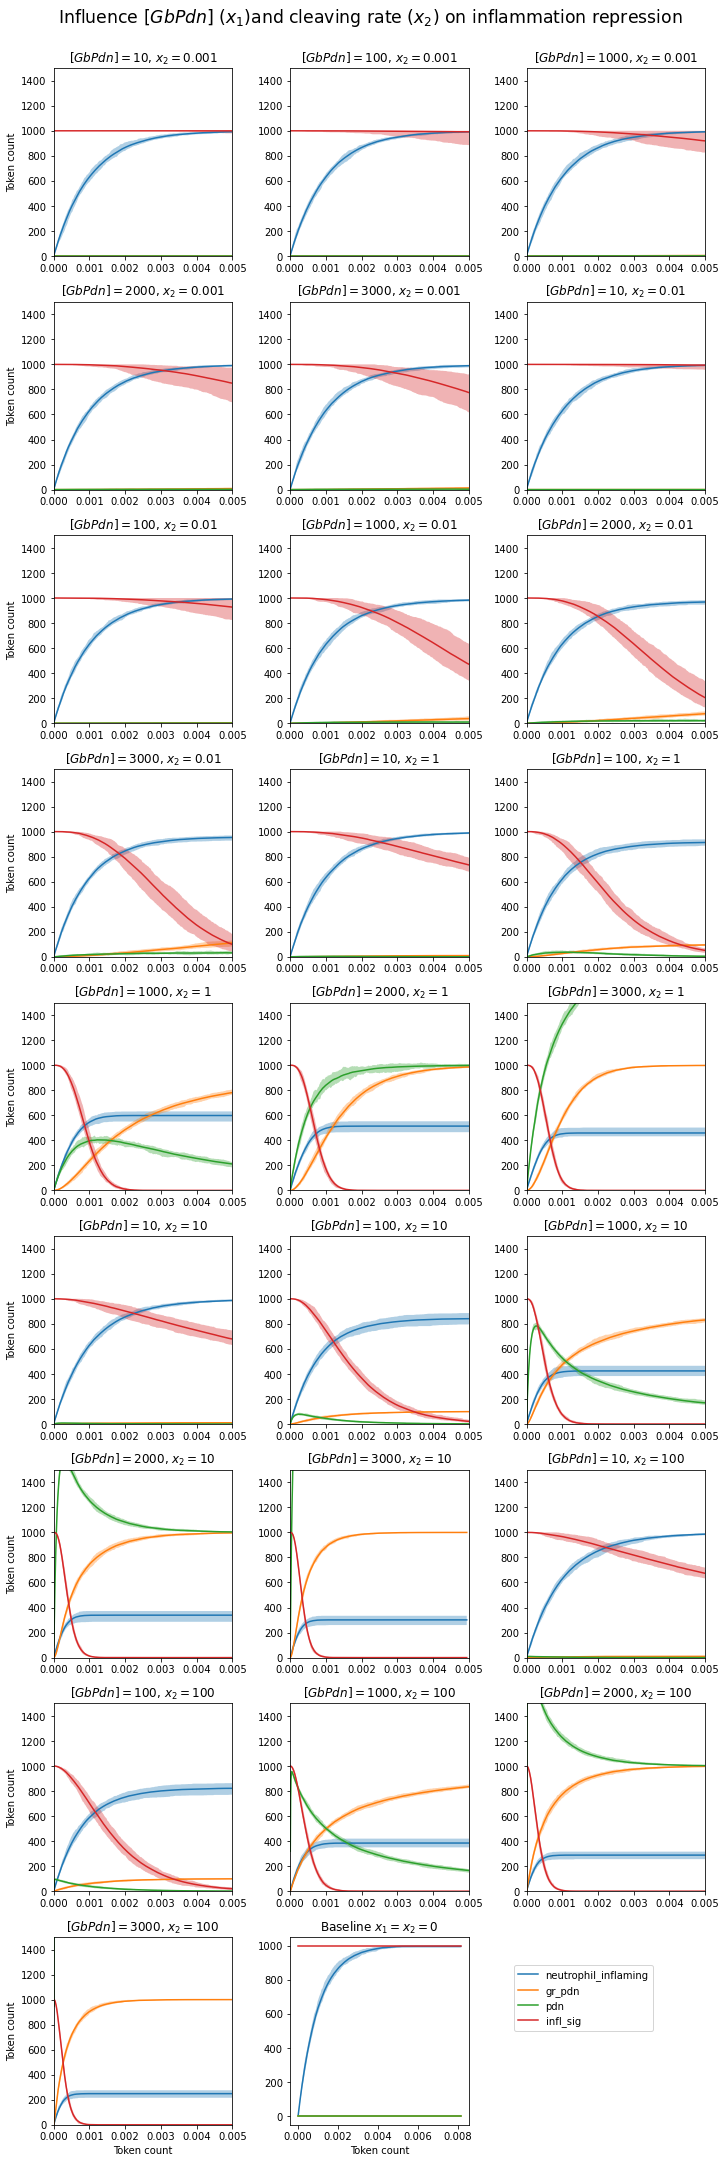

In [8]:
num_combos = len(GBPDN_INIT_MARKING_CHOICES) * len(CLEAVE_CONST_CHOICES)

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(10, 30))
fig.suptitle("Influence $[GbPdn]$ ($x_1$)and cleaving rate ($x_2$) "
             "on inflammation repression",
    y=1.0, fontsize="xx-large")
axes_vector = np.reshape(axes, (-1,))

PLOT_Y_VARS = ("neutrophil_inflaming", "gr_pdn", "pdn", "infl_sig")
PLOT_Y_LIMS = (0, 1500)
PLOT_X_LIMS = (0, 0.005)
PLOT_X_LABEL = "Simulated time"
PLOT_Y_LABEL = "Token count"

def load_log_and_hyperparams(exp_dir: str) -> Tuple[dict, dict]:
    """
    Load the logs JSON file and the hyperparameters JSON file
    stored in `exp_dir` as Python dictionaries.

    @param: exp_dir, path of directory to find JSON files in.
    @type exp_dir: str.

    @return: Tuple[dict, dict]: (logs, hyperparameters),
        "logs.json" and "hyperparameters.json" parsed
        to Python dictionaries.
    """
    logs_file =  os.path.join(exp_dir, "logs.json")
    hyperparams_file = os.path.join(exp_dir, "hyperparameters.json")
    logs = load_log(logs_file)
    hyperparams = load_log(hyperparams_file, False)
    return logs, hyperparams


for i in range(num_combos):
    exp_dir = os.path.join(CONST_UNBIND_SAVE_DIR, "x3_0__x4_0", f"exp_{i}")
    logs, hyperparams = load_log_and_hyperparams(exp_dir)

    num_timeboxes = get_num_timeboxes_for_fixed_duration(logs, 
        DESIRED_TIMEBOX_DURATION)
    # agg_logs, timebox_duration = aggregate_dataset_in_timeboxes(
    #     logs, x_var="time",
    #     y_vars=["neutrophil_inflaming", "gr_pdn", "pdn"], 
    #     num_timeboxes=num_timeboxes)

    # time_vect = [timebox_duration*t for t in range(num_timeboxes)]
    # timebox_idx = 0
    # while time_vect[timebox_idx] < COMPARISON_TIMESTAMP:
    #     timebox_idx += 1

    gbpdn_init_markings = hyperparams["gbpdn"]
    cleaving_rate_const = strip_prefix_number_from_string(hyperparams["cleave"])

    plot_results(logs, x_var="time", 
                 y_vars = PLOT_Y_VARS,
                 num_timeboxes=num_timeboxes, 
                 ax=axes_vector[i], add_legend=False)
    axes_vector[i].set(title=f"$[GbPdn]={gbpdn_init_markings}$, "
                       +f"$x_2={cleaving_rate_const}$",
        xlim=PLOT_X_LIMS, ylim=PLOT_Y_LIMS, xlabel=None)

# Add baseline to the last axes, for comparison.
plot_results(BASELINE_LOGS, x_var="time", y_vars=PLOT_Y_VARS,
             num_timeboxes=BASELINE_NUM_TIMEBOXES, 
             ax=axes_vector[i+1])
axes_vector[i+1].set(title="Baseline $x_1=x_2=0$")
axes_vector[i+2].remove()

plt.tight_layout()
axes_vector[i+1].legend(loc=(1.25, 0.5))

# Set y-labels only on the axes of left column in the figure
for i in range(9):
    axes[i, 0].set_ylabel(PLOT_Y_LABEL)
# Set x-label only for bottom plots.
axes[8, 0].set_xlabel(PLOT_Y_LABEL)
axes[8, 1].set_xlabel(PLOT_Y_LABEL)

fig.savefig(os.path.join(CONST_UNBIND_SAVE_DIR, "graphs.pdf"))



### Heatmap to quickly judge combinations of $x_1$ and $x_2$

Matrix where the row gives the cleave constant ($X_2$), the column
the initial amount of GbPdn ($x_1$), and the values
the observed neutrophils at `COMPARISON_TIMESTAMP`.

In [12]:
def gen_table_x1_x2_neutrophils(
    experiments_parent_dir: str, 
    x1_gbpdn_markings_choices: Sequence[int] = GBPDN_INIT_MARKING_CHOICES,
    x2_cleave_choices: Sequence[float|int] = CLEAVE_CONST_CHOICES
    ) -> np.ndarray:
    """
    Create a table that:
    * Has a column for each choice the the initial markings of GbPdn (x1).
    * Has a row for each choice of a Gba2-GbPdn-cleave-rate-constant (x2).
    * The values are the average amount of neutrophils 
        recorded after `COMPARISON_TIMESTAMP` time.
    Input must be a directory containing a subdirectory
    named 'exp_0', 'exp_1', ..., 'exp_n'
    for each of the `n+1` experiments that
    cover all possible combinations of (x1, x2) choices.

    @param experiments_parent_dir: directory containing the directories
        of individual experiments.
    @type experiments_parent_dir: str

    @param x1_gbpdn_markings_choices: all the values for the
        initial amount of tokens (x1) that were used in
        the experiments.
    @type x1_gbpdn_markings_choices: Sequence[int]

    @param x2_cleave_choices: all the values for the
        Gba2-GbPdn-cleave-rate-constant (x2) that were used in
        the experiments.
    @type x2_cleave_choices: Sequence[float | int]

    @return np.ndarray: table of floats,
        with `len(x2_cleave_choices)` rows,
        and `len(x1_gbpdn_markings_choices)` columns
        (as described above).
    """

    table = np.empty(shape=(len(x2_cleave_choices), len(x1_gbpdn_markings_choices)))

    for i in range(num_combos):
        exp_dir = os.path.join(experiments_parent_dir, f"exp_{i}")
        logs, hyperparams = load_log_and_hyperparams(exp_dir)

        num_timeboxes = get_num_timeboxes_for_fixed_duration(logs, 
            DESIRED_TIMEBOX_DURATION)

        agg_logs, timebox_duration = aggregate_dataset_in_timeboxes(
            logs, x_var="time",
            y_vars=["neutrophil_inflaming", "gr_pdn", "pdn"], 
            num_timeboxes=num_timeboxes)

        time_vect = [timebox_duration*t for t in range(num_timeboxes)]
        timebox_idx = 0
        while time_vect[timebox_idx] < COMPARISON_TIMESTAMP:
            timebox_idx += 1

        gbpdn_init_markings = hyperparams["gbpdn"]
        cleaving_rate_const = strip_prefix_number_from_string(hyperparams["cleave"])

        row_idx = x2_cleave_choices.index(eval(cleaving_rate_const))
        col_idx = x1_gbpdn_markings_choices.index(gbpdn_init_markings)

        neutrophils_at_comparison_time = np.mean(
            [run_vector[timebox_idx] 
            for run_vector in agg_logs["neutrophil_inflaming"]])

        table[row_idx, col_idx] = neutrophils_at_comparison_time
    return table

experiments_parent_dir = os.path.join(CONST_UNBIND_SAVE_DIR, "x3_0__x4_0")
table = gen_table_x1_x2_neutrophils(experiments_parent_dir)
print(table)


[[501.35       500.77       500.96733333 502.2075     497.52225397]
 [500.98       500.483      501.05283333 501.43246032 499.96238817]
 [504.01147619 497.42383333 465.18254928 444.3240052  420.74628535]
 [499.267      487.35282506 388.06563625 329.50600578 296.86166255]
 [498.71811905 477.91807521 358.18601909 282.41058009 246.57404762]]


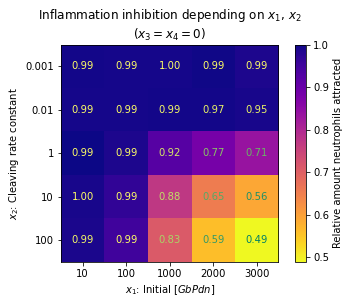

In [34]:
def make_heatmap(table: np.ndarray, 
                 col_labels: Sequence[str], 
                 row_labels:Sequence[str],
                 ax:Axes=None,
                 cmap: str | Colormap="plasma_r",
                 imshow_kwargs: Dict[str, Any] = {},
                 add_colorbar: bool=True
                 ) -> Tuple[Axes, AxesImage, Colorbar|None] :
    if ax is None:
        _, ax = plt.subplots()
    
    num_rows, num_cols = table.shape

    ax.set_yticks(np.arange(num_rows))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(num_cols))
    ax.set_xticklabels(col_labels)

    image = ax.imshow(table, cmap=cmap, **imshow_kwargs)

    if add_colorbar:
        colorbar = ax.figure.colorbar(image, ax=ax)
    else:
        colorbar = None

    min_val = np.min(table)
    max_val = np.max(table)
    num_values = table.size
    text_colors = cm.summer(np.linspace(0, 1, num_values))


    for row in range(num_rows):
        for col in range(num_cols):
            tab_value = table[row, col]
            label=f"{tab_value:.2f}"
            colour_idx = round(((tab_value - min_val)/(max_val-min_val)) * (num_values-1))
            ax.text(col, row, label, ha="center", va="center",
                color=text_colors[colour_idx])

    return ax, image, colorbar

ax, image, colorbar = make_heatmap(table/np.max(table), 
                    GBPDN_INIT_MARKING_CHOICES, CLEAVE_CONST_CHOICES)
ax.set_xlabel("$x_1$: Initial $[GbPdn]$")
ax.set_ylabel("$x_2$: Cleaving rate constant")
ax.set_title("Inflammation inhibition depending on $x_1$, $x_2$\n($x_3=x_4=0$)")
colorbar.ax.set_ylabel("Relative amount neutrophils attracted");

# Big experiment: $x_3$ and $x_4$ vary
Repeat the above experiment, but now for different values of
$x_3$ and $x_4$. For each combination of $(x_3, x_4)$,
make a heatmap with all combinations of $(x_1, x_2)$.
Then combine these heat-maps in a bigger table.

Note that this is basically finding way to represent 4-dimensional data.
It would unfortunately not be possible to visualize a 4D heatmap.

In [25]:

GRPDN_UNBIND_CONST_CHOICES = (0.01, 1, 100)
GRGBPDN_UNBIND_CONST_CHOICES = (0.01, 1, 100)

def x3_x4_combo_to_subdir_name(x3: float|int, x4: float|int) -> str:
    """
    Standardized way of mapping a combination between
    variables x3 and x4 to a name for the parent directory
    of all the experiment-directories.

    @param x3: Gr-Pdn unbind-rate-constant.
    @type x3: float|int

    @param x4: Gr-Pdn unbind-rate-constant.
    @type x4: float|int

    @return str: name for the directory.

    >>> x3_x4_combo_to_subdir_name(0.001, 100)
    "x3_1e-20__x4_1e+02"
    """
    return f"x3_{x3:.0e}__x4_{x4:.0e}"

def run_nested_grid_search(
    top_level_save_dir: str = VARYING_UNBIND_SAVE_DIR,
    x1_gbpdn_markings_choices: Sequence[int] = GBPDN_INIT_MARKING_CHOICES,
    x2_cleave_choices: Sequence[float|int] = CLEAVE_CONST_CHOICES,
    x3_grpdn_unbind_choices: Sequence[float|int] = GRPDN_UNBIND_CONST_CHOICES,
    x4_grgbpdn_unbind_choices: Sequence[float|int] = GRGBPDN_UNBIND_CONST_CHOICES
    ):

    all_x3_x4_combos = itertools.product(x3_grpdn_unbind_choices, 
                                         x4_grgbpdn_unbind_choices)
    for (x3_rate, x4_rate) in all_x3_x4_combos:
        print(f"Next (x3, x4) combination:{(x3_rate, x4_rate)}.")

        subdir_name = x3_x4_combo_to_subdir_name(x3_rate, x4_rate)
        subdir_path = os.path.join(top_level_save_dir, subdir_name)
        if not os.path.exists(subdir_path):
            os.mkdir(subdir_path)
        elif "exp_0" in os.listdir(subdir_path):
            print(f"Already data found for (x3, x4) "
            f"combination:{(x3_rate, x4_rate)}.\n"
            "Skipping this entire combination (skipping all x1, x2 combos).")
            continue
        print(f"Saving to path: {subdir_path}")

        all_rates_choices = setup_rates(
            cleave_rate_constants=x2_cleave_choices,
            gr_pdn_decay_constants=(x3_rate,),
            gr_gbpdn_decay_constants=(x4_rate,))

        all_markings_choices = setup_init_markings(x1_gbpdn_markings_choices)

        
        
        if not os.path.exists(os.path.join(subdir_path, "exp_0")):
            run_full_grid_search(rates_all_choices=all_rates_choices, 
                                init_markings_all_choices=all_markings_choices, 
                                top_level_save_dir=subdir_path,
                                num_repetitions=1, #NUM_REPETITIONS, 
                                max_steps=MAX_NUM_TRANSITIONS, 
                                max_time=MAX_TIME_PASSED)

In [26]:
run_nested_grid_search(VARYING_UNBIND_SAVE_DIR)

Next (x3, x4) combination:(0.01, 0.01).
Already data found for (x3, x4) combination:(0.01, 0.01).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(0.01, 1).
Already data found for (x3, x4) combination:(0.01, 1).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(0.01, 100).
Already data found for (x3, x4) combination:(0.01, 100).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(1, 0.01).
Already data found for (x3, x4) combination:(1, 0.01).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(1, 1).
Already data found for (x3, x4) combination:(1, 1).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(1, 100).
Already data found for (x3, x4) combination:(1, 100).
Skipping this entire combination (skipping all x1, x2 combos).
Next (x3, x4) combination:(100, 0.01).
Already data found for (x3, x

## Table of heatmaps

In [70]:
VMIN = 0.45
VMAX = 1.0
NORM = colors.Normalize(VMIN, VMAX)
CMAP = "plasma_r"

def make_table_of_heatmaps(
    top_level_save_dir: str = VARYING_UNBIND_SAVE_DIR,
    x1_gbpdn_markings_choices: Sequence[int] = GBPDN_INIT_MARKING_CHOICES,
    x2_cleave_choices: Sequence[float|int] = CLEAVE_CONST_CHOICES,
    x3_grpdn_unbind_choices: Sequence[float|int] = GRPDN_UNBIND_CONST_CHOICES,
    x4_grgbpdn_unbind_choices: Sequence[float|int] = GRGBPDN_UNBIND_CONST_CHOICES
    ):
    # all_x3_x4_combos = itertools.product(x3_grpdn_unbind_choices, 
    #                                      x4_grgbpdn_unbind_choices)
    # for (x3_rate, x4_rate) in all_x3_x4_combos:
    #     subdir_name = x3_x4_combo_to_subdir_name(x3_rate, x4_rate)
    # subdir_path = os.path.join(top_level_save_dir, subdir_name)

    num_cols = len(x3_grpdn_unbind_choices)
    num_rows = len(x4_grgbpdn_unbind_choices)

    axes = [[None for col in range(num_cols)] for row in range(num_rows)]
    images = [[None for col in range(num_cols)] for row in range(num_rows)]

    fig, superax = plt.subplots(figsize=(13, 13))
    superax.set_title("Neutrophils recruited depending on $x_1, x_2, x_3, x_4$")
    superax.set_xlabel("$x_3$:Gr-Pdn unbind rate constant")
    superax.set_ylabel("$x_4$:Gr-GbPdn unbind rate constant")
    superax_xlim = [0.2, num_cols+0.5]
    superax.set_xlim(superax_xlim)
    superax_ylim - [0.2, num_rows+0.5]
    superax.set_ylim(superax_ylim)
    superax.set_xticks([x for x in range(1, num_cols+1)])
    superax.set_yticks([y for y in range(1, num_rows+1)])
    superax.set_xticklabels(x3_grpdn_unbind_choices)
    superax.set_yticklabels(x4_grgbpdn_unbind_choices)

    superax.text(np.mean(superax_xlim), 0.4, 
        "$x_1$: Initial $[GbPdn]$", ha="center", va="center",
                color="black",
                in_layout=False)

    fig.execute_constrained_layout()
    value_to_color_mapping = cm.ScalarMappable(NORM, cmap=CMAP)
    colorbar = superax.figure.colorbar(value_to_color_mapping, 
                                        shrink=0.3,
                                        aspect=15,
                                        pad=0.01)#, ax=superax)
    colorbar.ax.set_ylabel("Relative amount neutrophils recruited")
    
    for level_1_dir in os.listdir(top_level_save_dir):
        dir_full_path = os.path.join(top_level_save_dir, level_1_dir)
        hyperparams = load_log(
            os.path.join(dir_full_path, "exp_0", "hyperparameters.json"), 
            convert_int_keys=False)
        x3 = eval(strip_prefix_number_from_string(hyperparams["unbind_pdn"]))
        col = x3_grpdn_unbind_choices.index(x3)
        x4 = eval(strip_prefix_number_from_string(hyperparams["unbind_gbpdn"]))
        row = x4_grgbpdn_unbind_choices.index(x4)
        table = gen_table_x1_x2_neutrophils(dir_full_path)
        table = table / MAX_NEUTROPHILS_RECRUITED

        bb_data_ax = Bbox.from_bounds(col+0.60,row+0.60, 0.8, 0.8)
        disp_coords = superax.transData.transform(bb_data_ax)
        fig_coords_ax = fig.transFigure.inverted().transform(disp_coords)
        bb_ax = Bbox(fig_coords_ax)
        ax = fig.add_axes(bb_ax)

        ax, img, _ = make_heatmap(table, 
            col_labels=x1_gbpdn_markings_choices,
            row_labels=x2_cleave_choices,
            ax=ax,
            add_colorbar=False,
            cmap=CMAP,
            imshow_kwargs = {
                "vmin":VMIN,
                "vmax":VMAX})

        axes[row][col] = ax
        images[row][col] = img
    
    # All images have the same colour-mapping, so we can just pick the first.
    
    #     print(level_1_dir)

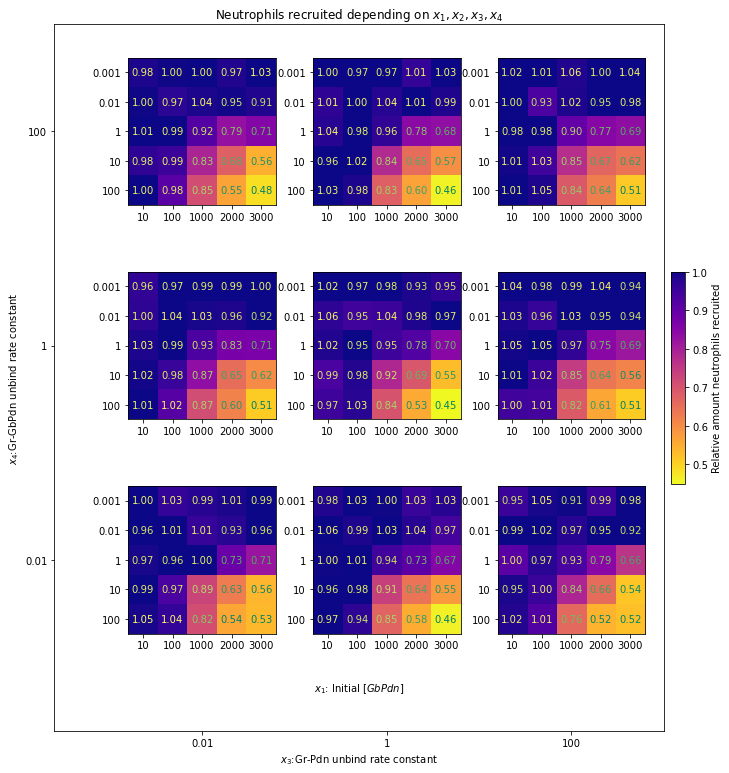

In [71]:
make_table_of_heatmaps()

In [49]:
# del make_heatmap
del make_table_of_heatmaps